<center><h1 style="color:#173F8A;"> Metodos para Ecuaciones Diferenciales, IMT3410, 2022-2 </h1></center>
<h3 style="color:#173F8A;text-align:right;"> Instituto de Ingenieria Matematica y Computacional<br>  Pontificia Universidad Catolica de Chile <br>  </h3>
<h3 style="color:#0176DE;text-align:right;"> Profesor. Manuel A. Sanchez<br> </h3>
<hr style="border:2px solid #03122E"> </hr>

<!-- Palette colors UC: celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 -->
<!--
<figure>
<img align ="right" src="IMClogo.png" alt="logo" width="250" height="400"><br><br><br><br><br>
</figure>
 -->

<h2 style="color:#03122E;text-align:center;"> Capitulo 3. Metodos para Ecuaciones Diferenciales Parciales Hiperbolicas<br> </h2>

<hr style="border:3px solid #E3AE00 "> </hr>

## Ecuacion hiperbolica con viscocidad en una dimension

Resolvemos el problema en una dimension:
\begin{equation}
\begin{array}{rclrl}
-\varepsilon \frac{d^{2}}{dx^{2}}u + a\frac{d}{dx}u &=& f(x)&\mbox{en} & (a,b) \\
u &=&u_D&\mbox{sobre}& \{a,b\}
\end{array}
\end{equation}


In [128]:
# use netgen.meshing module for 1d meshes
from ngsolve import *
from netgen.meshing import Mesh as Mesh1d
from netgen.meshing import MeshPoint,Element0D, Element1D
from netgen.csg import *
import numpy as np
import matplotlib as plt

In [141]:
# Problem data
class problem_hyperbolic1D:
    def __init__(self):
        # Geometry Interval
        self.a = 0; self.b = 1
        # diffusion
        self.epsilon = 0.001
        # convection
        self.beta = 1.0
        # 
        self.force = CoefficientFunction(0)
        # Boundary condition
        self.Dirichlet = "left|right"
        self.uD_l = 1.0
        self.uD_r = 0.0 

In [142]:
from ngsolve import *
def uniform_1d_mesh(a=0,b=1,N=10, material='material'):
    """ returns a mesh of interval (a,b) with nel elements
    """
    #m = Mesh()
    m = Mesh1d(dim=1)
    pnums = []
    for i in range(0, N+1):
        pnums.append (m.Add (MeshPoint (Pnt(i/N, 0, 0))))
    idx = m.AddRegion("material", dim=1)
    for i in range(0,N):
        m.Add (Element1D ([pnums[i],pnums[i+1]], index=idx))

    idx_left = m.AddRegion("left", dim=0)
    idx_right = m.AddRegion("right", dim=0)

    m.Add (Element0D (pnums[0], index=idx_left))
    m.Add (Element0D (pnums[N], index=idx_right))

    return m, pnums

In [143]:
import numpy as np
import matplotlib.pyplot as plt
def plot1D(mesh, gf, exact=None):
    xx  = [v.point[0] for v in mesh.vertices] 
    u0 = [0          for v in mesh.vertices]

    fig, ax = plt.subplots(1,1)
    uhplot = []
    subdiv = p
    for el in mesh.Elements(VOL):
        xvlocal = np.linspace( mesh[el.vertices[0]].point[0]+10**-5, mesh[el.vertices[1]].point[0]-10**-5, subdiv+1)
        uhlocal = []
        for xlocal in xvlocal:
            mip = mesh(xlocal)
            uhlocal.append(gf(mip))
        line_uh, = ax.plot(xvlocal, uhlocal, color='C0')
    line_uh.set_label(r'$u_h$')
    
    if exact is not None:
        
        xplot = np.linspace(0,1,200)
        ax.plot(xplot, uexact(xplot), 'C03')
    plt.show()

In [144]:
def standardGalerkin(problem, mesh, p=1):
    # Finite Element Space
    Vh = H1(mesh, order=p, dirichlet=problem.Dirichlet)
    uh, v = Vh.TnT()
    # bilinear form
    a = BilinearForm(Vh)
    a += problem.epsilon*grad(uh)*grad(v)*dx
    #a += h*grad(uh)*grad(v)*dx
    a += problem.beta*grad(uh)*v*dx

    a.Assemble()
    # linear form
    f = LinearForm(Vh)
    f += problem.force*v*dx
    f.Assemble()

    gf = GridFunction(Vh,"u")
    uD  = mesh.BoundaryCF({ "left" : problem.uD_l,"right" : problem.uD_r})
    gf.Set(uD,BND) 
    r = f.vec.CreateVector()
    r.data = f.vec - a.mat * gf.vec
    gf.vec.data += a.mat.Inverse(Vh.FreeDofs()) * r
    return gf

In [145]:
def Galerkin_artificialdiffusion(problem, mesh, p=1):
    # Finite Element Space
    Vh = H1(mesh, order=p, dirichlet=problem.Dirichlet)
    uh, v = Vh.TnT()
    # bilinear form
    h = specialcf.mesh_size
    delta = h - problem.epsilon
    a = BilinearForm(Vh)
    a += problem.epsilon*grad(uh)*grad(v)*dx
    a += delta*grad(uh)*grad(v)*dx
    a += problem.beta*grad(uh)*v*dx

    a.Assemble()
    # linear form
    f = LinearForm(Vh)
    f += problem.force*v*dx
    f.Assemble()

    gf = GridFunction(Vh,"u")
    uD  = mesh.BoundaryCF({ "left" : problem.uD_l,"right" : problem.uD_r})
    gf.Set(uD,BND) 
    r = f.vec.CreateVector()
    r.data = f.vec - a.mat * gf.vec
    gf.vec.data += a.mat.Inverse(Vh.FreeDofs()) * r
    return gf

In [146]:
def Galerkin_streamlinediffusion(problem, mesh, p=1):
    # Finite Element Space
    Vh = H1(mesh, order=p, dirichlet=problem.Dirichlet)
    uh, v = Vh.TnT()
    # bilinear form
    h = specialcf.mesh_size
    a = BilinearForm(Vh)
    a += h*grad(uh)*grad(v)*dx
    a += problem.beta*grad(uh)*v*dx

    a.Assemble()
    # linear form
    f = LinearForm(Vh)
    f += problem.force*v*dx
    f.Assemble()

    gf = GridFunction(Vh,"u")
    uD  = mesh.BoundaryCF({ "left" : problem.uD_l,"right" : problem.uD_r})
    gf.Set(uD,BND) 
    r = f.vec.CreateVector()
    r.data = f.vec - a.mat * gf.vec
    gf.vec.data += a.mat.Inverse(Vh.FreeDofs()) * r
    return gf

In [156]:
problem = problem_hyperbolic1D()
N = 101; h = 1.0/N
m, pnums = uniform_1d_mesh(problem.a,problem.b,N)
mesh = Mesh(m)

gf_sG = standardGalerkin(problem, mesh, p=1)
gf_Gad = Galerkin_artificialdiffusion(problem, mesh, p=1)

uexact = lambda x: 1/(1-np.exp(-1/epsilon))*(1-np.exp(-(1-x)/epsilon))

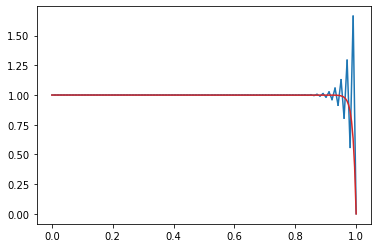

In [157]:
plot1D(mesh, gf_sG, uexact)

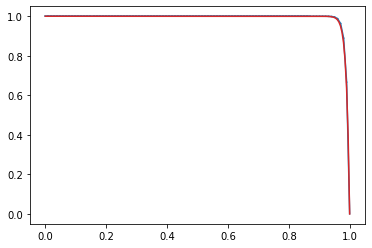

In [158]:
plot1D(mesh, gf_Gad, uexact)